# Setup: OpenCV

For this assignment you will need to use a popular and powerful library known as [OpenCV](https://opencv.org/). To do this on hub, you will need to open a terminal (File->New Launcher->Terminal) and enter `pip install opencv-python`. If you are trying to run the notebook somewhere else and can't figure out how to install the library, ask on piazza and provide details.

# Assignment: Solving Image Maze 

Given a maze as an image with a initial and end point, we would like to write code to solve the maze. 

An image is a 2D matrix of pixels of a particular size that depends on its resolution. Each 
pixel has a color which is given by its Red, Green and Blue (RGB) values.
 
Given an image, we will view it as a graph where each pixel of the image is a vertex 
and edges connect a pixel to its neighbor. The weight of an edge should be very small if
the pixel colors are similar (i.e, the differences between r, g and b values are close to zero)
and correspondingly large as the pixel colors diverge.
  
Next, given a source pixel $(i_0, j_0)$ and destination pixel, 
$(i_1, j_1)$, we wish find the shortest weight path from source to destination.

You should use the Dijkstra's algorithm modified in two ways:
   - It can exit as soon as the destination is reached.
   - A 1000 x 1000 pixel image gives rise to a graph with million vertices. Storing such a graph as an adjacency list is going to be very memory intensive. Instead, your goal will be to generate the vertices and edges *on-the-fly*.
   
We will use opencv library, a popular computer vision library to load, and manipulate images of mazes.


## Manipulating Images

You can directly manipulate images in python in many ways. The `opencv` library is considered a standard for numerous
image manipulation tasks.

Here we load an image `maze.png` and you can see it nicely plotted with coordinates. We then show you two pixels
shown in red and blue. The goal here is to detect a path from one of the colored circle to the other, in the maze without crossing
the black pixels.

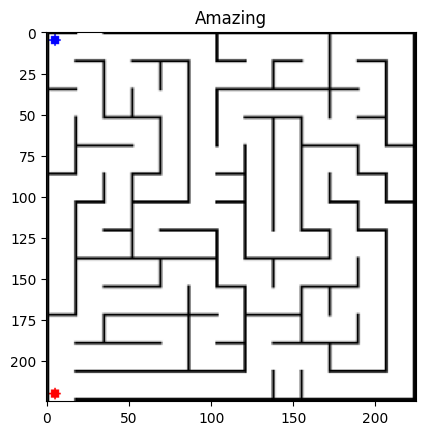

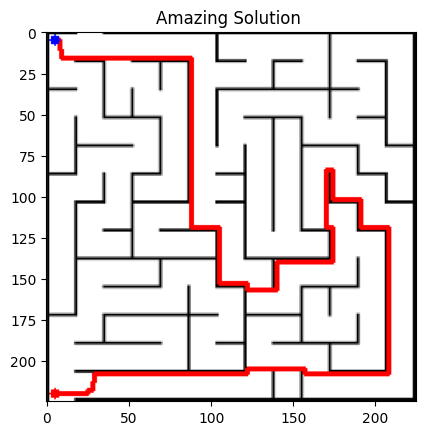

In [123]:
from matplotlib import pyplot as plt
import cv2
# You can read png, jpg and other file types 
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

img = cv2.imread('maze-solution.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing Solution ')
plt.show()


Given an image it is simple to read the color at a pixel. Let us read the color at pixel (645, 67)

In [124]:
print('Image size (height, width, num layers) is', img.shape)
px = img[145, 67] # img[y,x] is the color of the pixel of x,y
print(px)

cv2.circle(img, (80, 18), 3, (198,31,4),-1) # Draw a colored circle centered at (80, 18)
px1 = img[18, 80] # It is important to note that rows of the image are y values and columns are x values.
print(px1)

px2 = img[80, 18] # This is important to note that indexing the img data structure takes y, x values.
# Most opencv functions will require (x,y) coordinates for pixel as is natural.
print(px2)

Image size (height, width, num layers) is (225, 225, 3)
[255 255 255]
[198  31   4]
[0 0 0]


The pixel color is expressed in RGB format. R is the red value from 0 -> 255, G is the green value 0 -> 255 and B is the blue value from 0 -> 255 

We will now define a edge weight function for an edge in the image

In [125]:
import math 
def fixPixelValues(px):
    # convert the RGB values into floating point to avoid an overflow that will give me wrong answers
    return [ float(px[0]), float(px[1]), float(px[2]) ]

## Given (x,y) coordinates of two neighboring pixels, calculate the edge weight.
# We take the squared euclidean distance between the pixel values and add 0.1
def getEdgeWeight(img, u, v):
    # get edge weight for edge between u, v
    # First make sure that the edge is legit
    i0,j0 = u[0], u[1]
    i1,j1 = v[0], v[1]
    height, width, _ = img.shape
    assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height # pixel position valid?
    assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height # pixel position valid?
    assert -1 <= i0 - i1 <= 1 # edge between node and neighbor?
    assert -1 <= j0 - j1 <= 1
    px1 = fixPixelValues(img[j0,i0])
    px2 = fixPixelValues(img[j1,i1])
    return 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2]- px2[2])**2
    
# This is a useful function that given a list of (x,y) values, 
# draw a series of red lines between each coordinate and next to 
# show the path in the image
def drawPath(img, path, pThick=2):
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv2.line(img,(x,y), (x0,y0), (255,0,0),pThick)
        x0, y0 = x,y
        

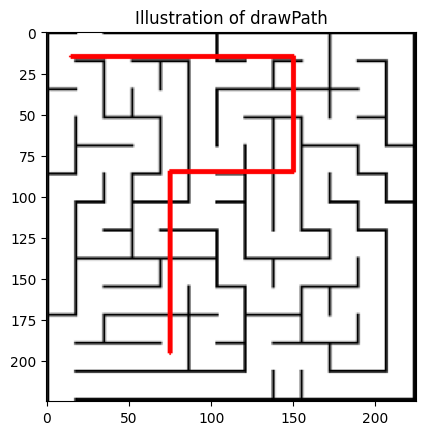

In [126]:
# Example
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
drawPath(img, [ (15, 15), (150, 15), (150, 85), (75, 85), (75, 195)])
plt.imshow(img) # show the image on the screen 
plt.title('Illustration of drawPath')
plt.show()

## Step 1: Compute Single Source Shortest Path For an Image

Given an image, compute the  shortest path between source and destination pixels by modifying Dijkstra's algorithm. __Your challenge  is to implement it without needing to create the entire the adjacency list for the graph
in the first place. However, for simplicity you can try a first cut implementation of a generic Dijkstra algorithm over
graphs represented as adjacency matrix or list.__ 

In [127]:
class Vertex: # This is the outline for a vertex data structure
    def __init__ (self,  i, j):
        self.x = i # The x coordinate
        self.y = j  # The y coordinate
        self.d = float('inf') # the shortest path estimate
        self.processed = False # Has this vertex's final shortest path distance been computed
        self.idx_in_priority_queue = -1 # The index of this vertex in the queue
        self.pi = None # the parent vertex.
    
        
# Dijkstra's algorithm requires a priority queue so that the 
# minimum weight vertex can be found efficiently.
# However, we provide you with a list data structure as a stand in for priority queue

class SimpleQueue: 
    # CONSTRUCTOR
    def __init__(self): 
        self.q = []
        
    # Insert a vertex into the queue
    def insert(self, v):
        v.idx_in_priority_queue = len(self.q)
        self.q.append(v)
        
    # Find the vertex with the smallest distance estimate, and 
    # delete it from the queue
    # return the vertex
    def get_and_delete_min(self):
        n = len(self.q)
        assert n > 0
        min_pos = 0
        for i in range(n):
            if self.q[i].d < self.q[min_pos].d:
                min_pos = i
        v = self.q[min_pos]
        del self.q[min_pos]
        return v
    
    # Is the queue empty?
    def is_empty(self):
        return len(self.q) == 0
    
    # Notify the queue that the weight of vertex v has been updated.
    def update_vertex_weight(self, v):
        pass # Nothing to do, for a simple list, we ignore this notification.
    


In [128]:
# However, if you want Dijkstra efficiently, 
# you may want to implement a priority queue.
# We provide you the signature for a priority queue.
# Feel free to implement extra functions if you wish
import heapq

class PriorityQueue:
    # Constructor: 
    def __init__(self):
        pass # YOUR CODE HERE
    
    def insert(self, v):
        pass # YOUR CODE HERE
    
    def get_and_delete_min(self):
        pass # YOUR CODE HERE: must return a vertex
    def is_empty(self):
        pass # YOUR CODE HERE: must return true/false
        
    def update_vertex_weight(self, v):
        pass # YOUR CODE HERE

In [129]:
# https://www.geeksforgeeks.org/python-program-for-dijkstras-shortest-path-algorithm-greedy-algo-7/
# Helper functions
""" in_bounds - Checks if a given coordinate is within the defined boundaries of the maze.
    Input:
        present (int): The coordinate (either x or y) of a vertex to be checked
        size (int): The maximum allowable value for the coordinate (derived from image dimensions)
    Process:
        * The function verifies if the 'present' coordinate is between 0 (inclusive) and 'size' (exclusive)
    Output:
        bool: Returns True if the coordinate is within bounds, False otherwise
"""
def in_bounds(present, size):
    # Check and return if the coordinate is within the acceptable range
    return 0 <= present < size

""" relax - Updates the shortest path estimate and predecessor for an adjacent vertex.
    Input:
        img (numpy.ndarray): The image of the maze where each pixel corresponds to a vertex
        present (Vertex): The current vertex being processed (typically the vertex dequeued from the priority queue)
        adjacent (Vertex): A neighboring vertex to the 'present' vertex whose properties might be updated
    Algorithm:
        * Calculate the edge weight between the 'present' vertex and its 'adjacent' neighbor using their pixel values
        * If a shorter path to the 'adjacent' vertex is found (i.e., current distance estimate + edge weight < known shortest distance), 
        update the 'adjacent' vertex's distance estimate and set its predecessor to the 'present' vertex
    Output:
        None - The function modifies the properties of the 'adjacent' vertex directly if a shorter path is found
"""
def relax(img, present, adjacent):
    # Compute the weight of the edge between current and adjacent vertices based on their pixel values
    weight = getEdgeWeight(img, (present.x, present.y), (adjacent.x, adjacent.y))
    # Check if the path through 'present' to 'adjacent' is shorter than the known shortest path
    if adjacent.d > present.d + weight:
        # Update the shortest path estimate for 'adjacent'
        adjacent.pi = present  # Set predecessor
        adjacent.d = present.d + weight  # Update shortest path distance estimate


""" neighborFinder - Identifies and processes all neighboring vertices of a given vertex in the maze image.
    Input:
        img (numpy.ndarray): The image of the maze where the path is to be found. Each pixel corresponds to a vertex.
        queue (list): The priority queue (min-heap) used in Dijkstra's algorithm for storing vertices to be explored.
        present (Vertex): The current vertex being processed.
        visited (dict): A dictionary that maps coordinates to Vertex objects to track which vertices have been visited and their properties.
    Algorithm:
        * Determine the dimensions of the image to ensure neighbor validity.
        * Define possible movements to neighboring pixels (vertices).
        * For each possible movement, check if the move is within the bounds of the image.
        * If the neighbor has not been visited, create a new Vertex, relax the edge, and add it to the queue and visited list.
        * If already visited, just relax the edge to potentially update the shortest path estimate.
    Output:
        None - The function modifies the queue and visited dictionary in-place.
"""
def neighborFinder(img, queue, present, visited):
    # Extract the dimensions of the image for boundary checks
    height, width, _ = img.shape
    # Define the relative positions of possible neighbors (up, down, left, right)
    neighbors = [
        (present.x+1, present.y), (present.x-1, present.y),
        (present.x, present.y+1), (present.x, present.y-1)
    ]
    # Process each neighbor
    for nx, ny in neighbors:
        # Ensure the neighbor is within the image boundaries
        if in_bounds(nx, width) and in_bounds(ny, height):
            # Check if the neighbor has been visited
            if (nx, ny) not in visited:
                # Create a new vertex for the unvisited neighbor
                adjacent = Vertex(nx, ny)
                # Mark the neighbor as visited and store in the dictionary
                visited[(nx, ny)] = adjacent
                # Update the shortest path estimate using the relax function
                relax(img, present, adjacent)
                # Add the new vertex to the priority queue
                heapq.heappush(queue, (adjacent.d, nx, ny, adjacent))
            else:
                # Retrieve the visited neighbor
                adjacent = visited[(nx, ny)]
                # Update the shortest path estimate if possible
                relax(img, present, adjacent)


""" computeShortestPath - Computes the shortest path in a maze using Dijkstra's algorithm.
    Input:
        img (numpy.ndarray): The image of the maze where the path is to be found. Each pixel represents a vertex
        source (tuple): A tuple (x, y) representing the starting pixel (vertex) coordinates in the image
        dest (tuple): A tuple (x, y) representing the destination pixel (vertex) coordinates in the image
    Algorithm:
        * Initialize the starting vertex and set its distance to zero
        * Use a priority queue (min-heap) to repeatedly find the vertex with the smallest distance
        * Explore each vertex only once by marking it visited and storing it in a dictionary
        * For each vertex, calculate the distance to its neighbors and update their distances if a shorter path is found
        * Stop when the destination vertex is dequeued, indicating the shortest path has been found
        * Backtrack from the destination vertex to the source vertex to construct the path list
    Output:
        path (list of tuples): The shortest path from source to destination as a list of (x, y) tuples.
"""
def computeShortestPath(img, source, dest):
    # Initialize the start vertex with distance 0 and push it into the priority queue
    initial = Vertex(source[0], source[1])
    initial.d = 0  # Set the initial distance to zero
    queue = []  # Priority queue to hold vertices to be processed
    heapq.heappush(queue, (initial.d, initial.x, initial.y, initial))  # Push the initial vertex
    visited = {source: initial}  # Dictionary to track visited vertices
    # Process the queue until it is empty
    while queue:
        _, _, _, present = heapq.heappop(queue)  # Pop the vertex with the smallest distance
        # Check if the current vertex is the destination
        if (present.x == dest[0] and present.y == dest[1]):
            break  # Stop processing if the destination is reached
        neighborFinder(img, queue, present, visited)  # Find and process all neighbors
    # Backtrack to find the path from destination to source
    path = []  # List to store the path
    while present:
        path.insert(0, (present.x, present.y))  # Insert the vertex at the beginning of the path list
        present = present.pi  # Move to the previous vertex in the path
    return path  # Return the computed path


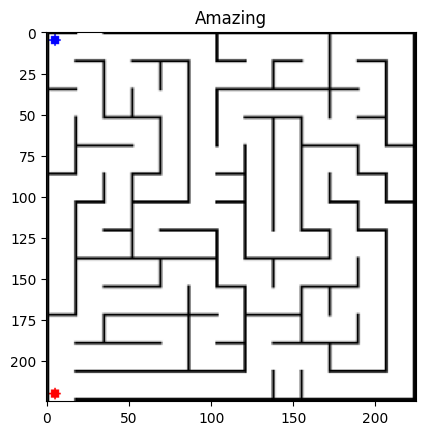

In [130]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

In [131]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (5,220), (5,5))

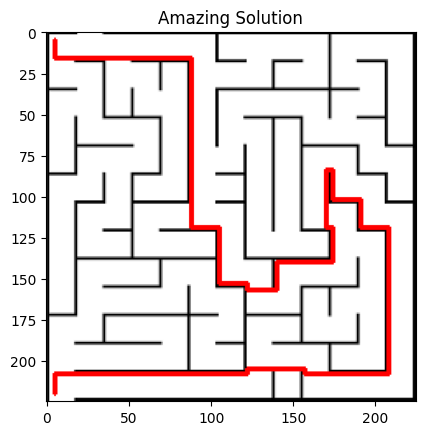

True

In [132]:
drawPath(img, p)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing Solution')
plt.show()
cv2.imwrite('Amazing Solution.png', img)

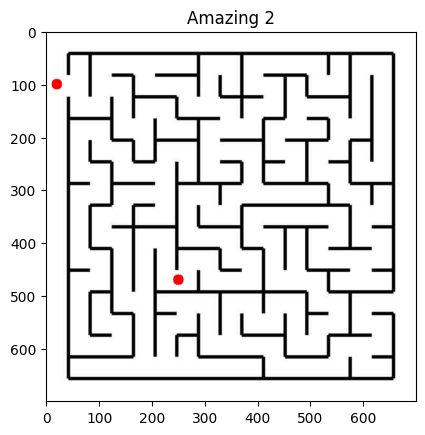

In [133]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
cv2.circle(img,(250,470), 10, (255,0,0), -1) # add a circle centered at (250, 470) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (20,100), 10, (255,0,0), -1) # add a circle centered at (20, 100) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 2')
plt.show()

In [134]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (250,470), (20,100))

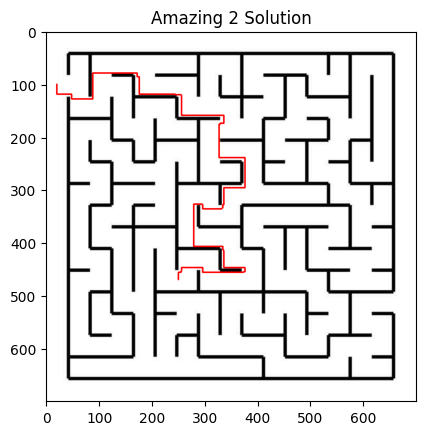

True

In [135]:
drawPath(img,p)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 2 Solution')
plt.show()
cv2.imwrite('Amazing 2 Solution.png', img)

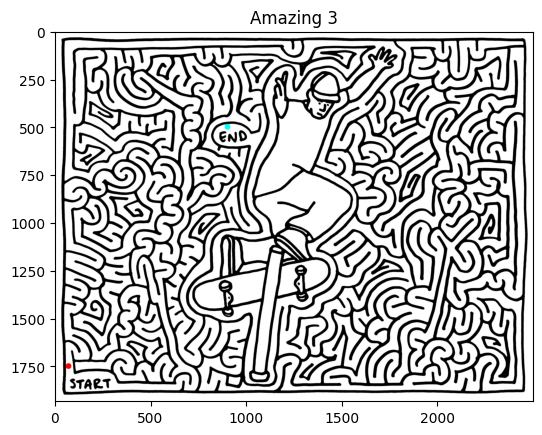

In [136]:
img = cv2.imread('maze3.JPG')
cv2.circle(img,(70,1750), 15, (255,0,0), -1) # add a circle centered at (70, 1750) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (900,500), 15, (0,255,255), -1) # add a circle centered at (900, 500) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 3')
plt.show()

In [137]:
img = cv2.imread('maze3.JPG') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (70,1750), (900,500))

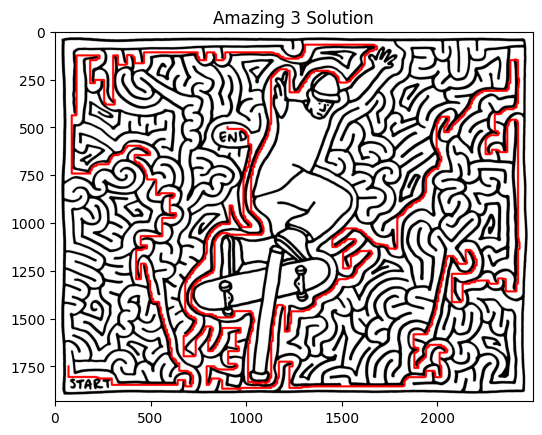

True

In [138]:
drawPath(img,p,10)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 3 Solution')
plt.show()
cv2.imwrite('Amazing 3 Solution.png', img)